# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [38]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [39]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv")
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [40]:
#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).apply(lambda x: x.timestamp())

## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the Prediction horizon.It determined how far we are making the prediction.Prediction horizon (ph) is a parameter that defines the number of time steps or intervals into the future that we want to predict.
mu is Forgetting factor.The purpose of the mu is ,it exponentially decays the data from the history.By using a forgetting factor, the model can adapt to changes in the data distribution over time and avoid overfitting to the historical data. It also enables the model to learn from data that may be more relevant or representative of the current situation.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [41]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index =  int(ph / (df['unix'].iloc[1] - df['unix'].iloc[0]))
#ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:
The weight given to each data point will drop exponentially as we move farther away from the current time step, assuming we are using a forgetting factor or exponential smoothing with a parameter of mu=0.9. The weight that is specifically applied to the ith data point will be mu(t-i), where t denotes the current time step and i denotes the ith data point's time step.
In our case, we are interested in the weight assigned to the first data point (i=1) on the last prediction (t=5000). Using the formula above, we can calculate the weight as:

mu^(5000-1) = 0.9^4999 ≈ 1.59e-15
This means that the first data point will have a very small weight (approximately 1.59e-15) on the last prediction in our limited dataset, due to the effect of the forgetting factor.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [42]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

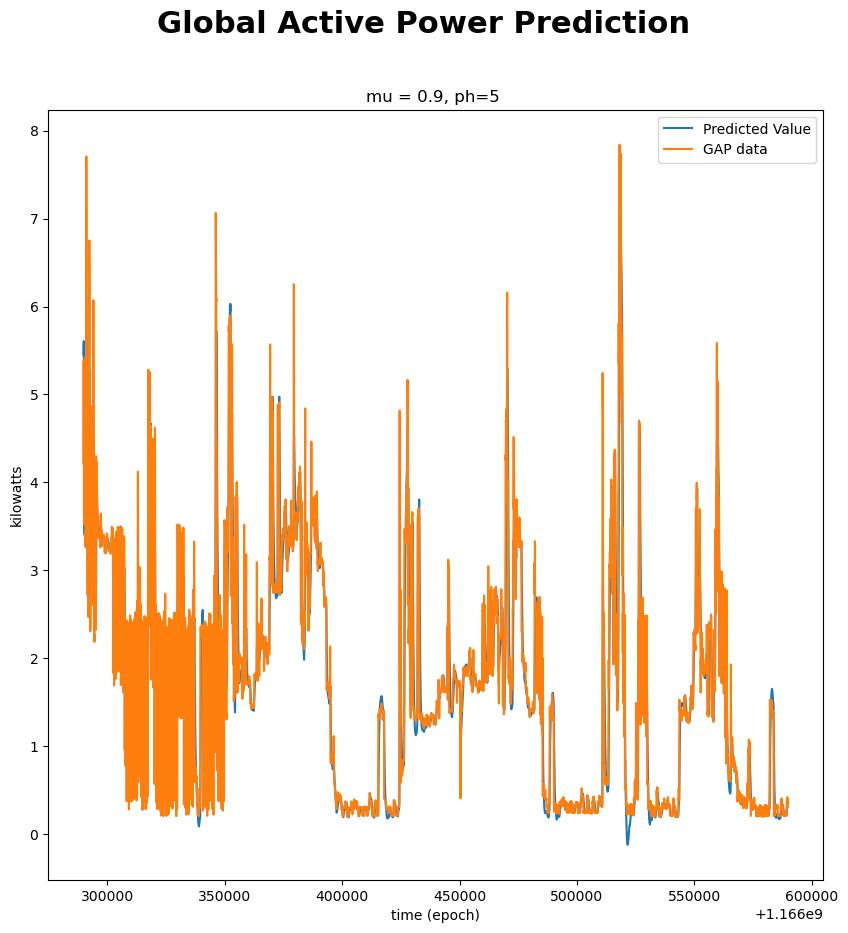

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

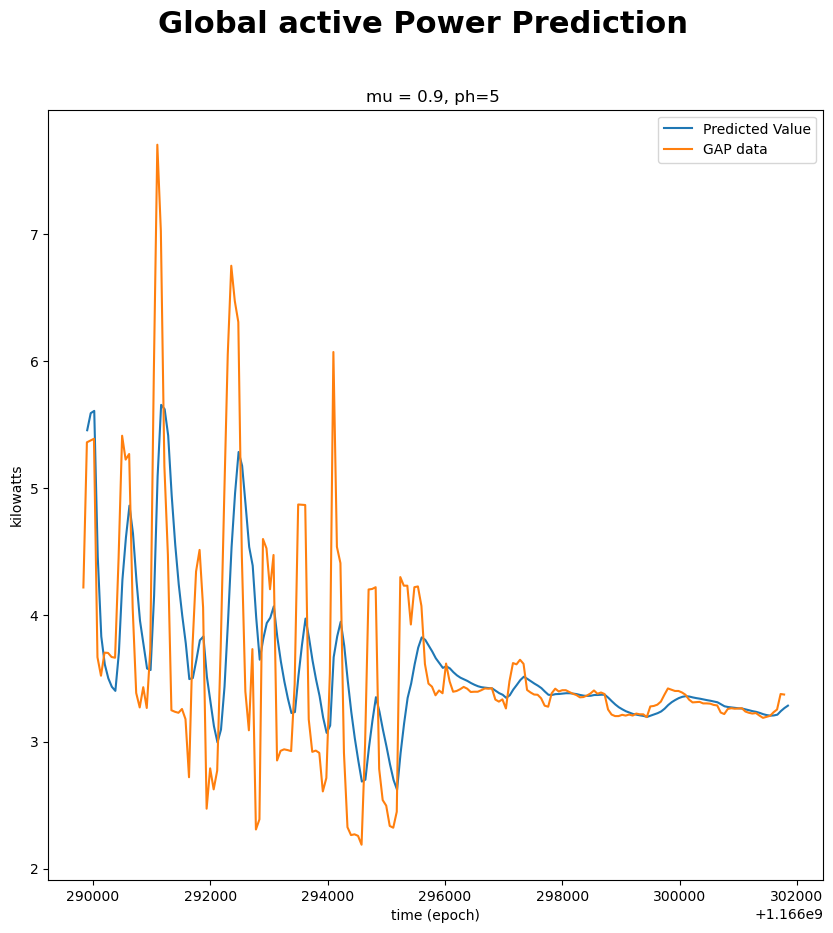

In [44]:
#Plot first 200 data points/predictions
total=[l for l in range(int(min(tp_pred)),int(min(tp_pred+3000)))]
thre=70*np.ones(len(total))
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction',fontsize=22,fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


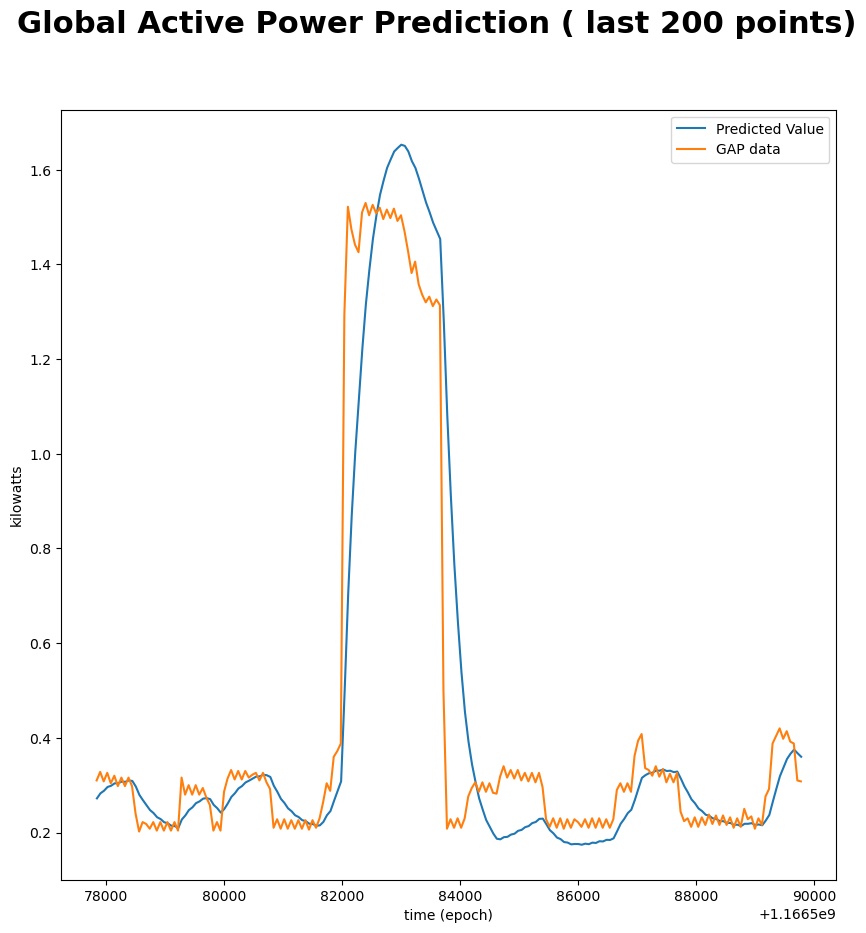

In [46]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction ( last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [47]:
#Calculate MSE of predictions
from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.17650896514023476


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: From the charts, I observed that our model has some degree of accuracy in predicting the global active power consumption. However, there are some significant differences between the early and the late predictions.The early predictions seem to be closer to the actual values than the later predictions.
The MSE value indicates the average squared difference between the predicted values and the actual values. The MSE can help us better understand how our model is performing. If the MSE is low, it means that our model is making accurate predictions. On the other hand, if the MSE is high, it means that our model is making inaccurate predictions.
.In this case, the MSE value is 0.176, which suggests that the model has some errors in its predictions, but overall it performs reasonably well.


**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [48]:
#mu=1
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index =  int(ph / (df['unix'].iloc[1] - df['unix'].iloc[0]))
#ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [49]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

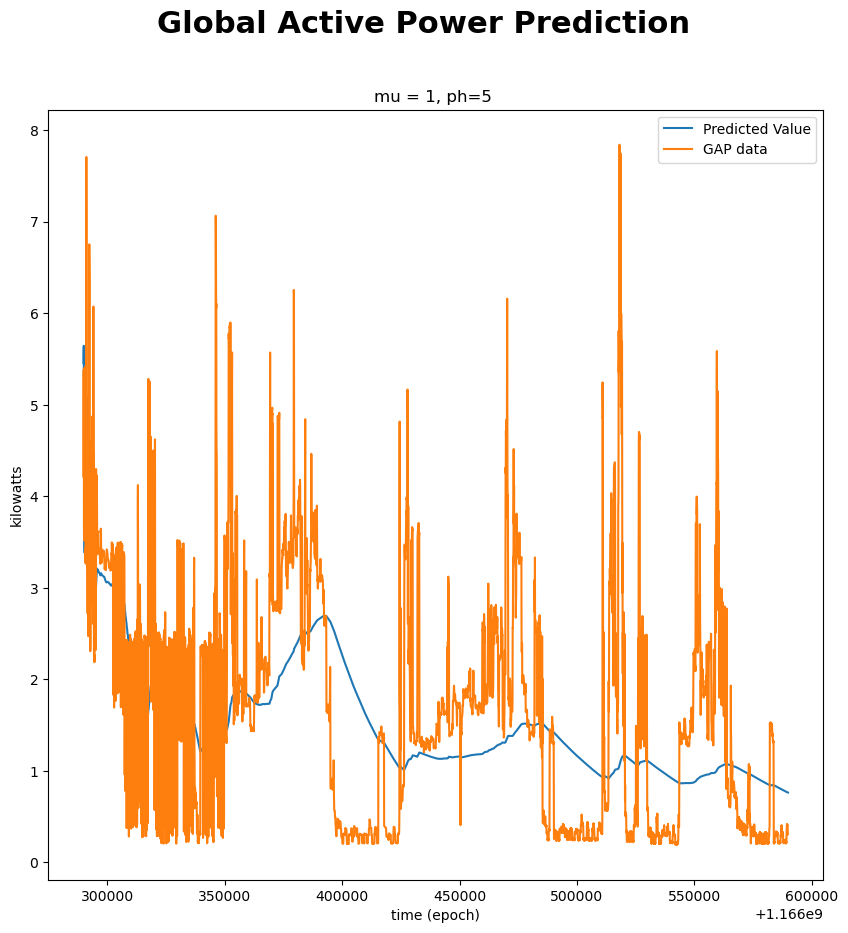

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

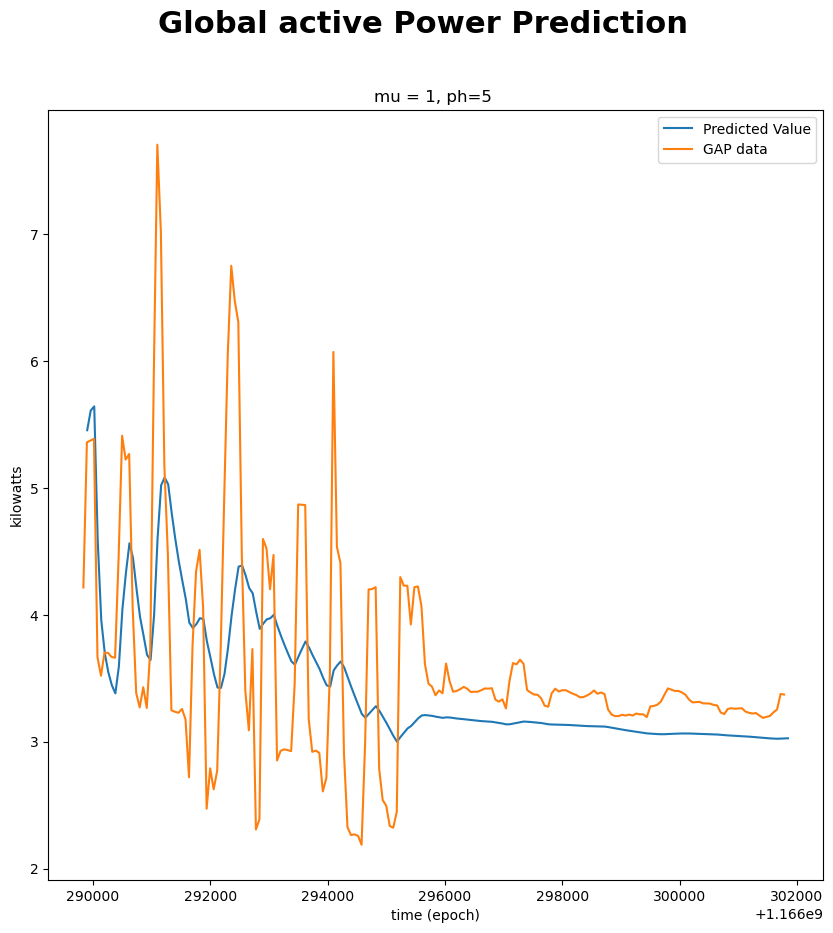

In [51]:
#Plot first 200 data points/predictions for mu = 1
total=[l for l in range(int(min(tp_pred)),int(min(tp_pred+3000)))]
thre=70*np.ones(len(total))
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction',fontsize=22,fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


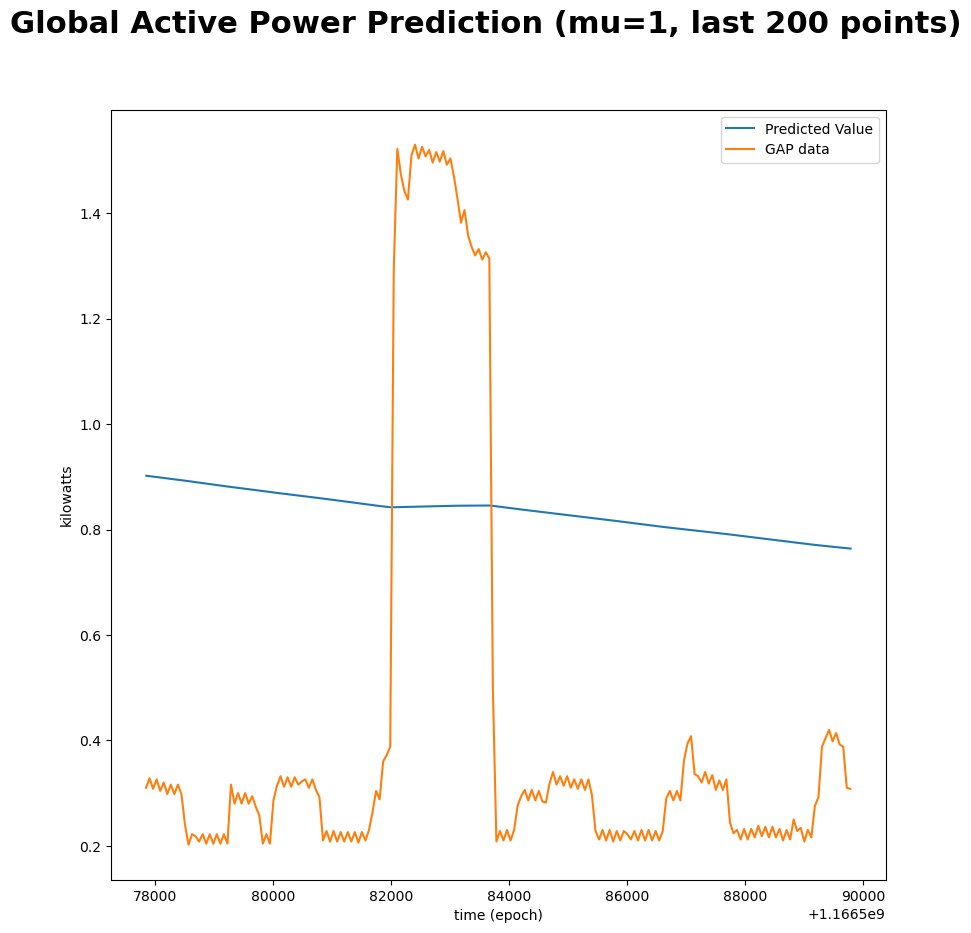

In [52]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=1, last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [53]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3765548530707918


In [54]:
#mu=0.01
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index =  int(ph / (df['unix'].iloc[1] - df['unix'].iloc[0]))
#ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [55]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

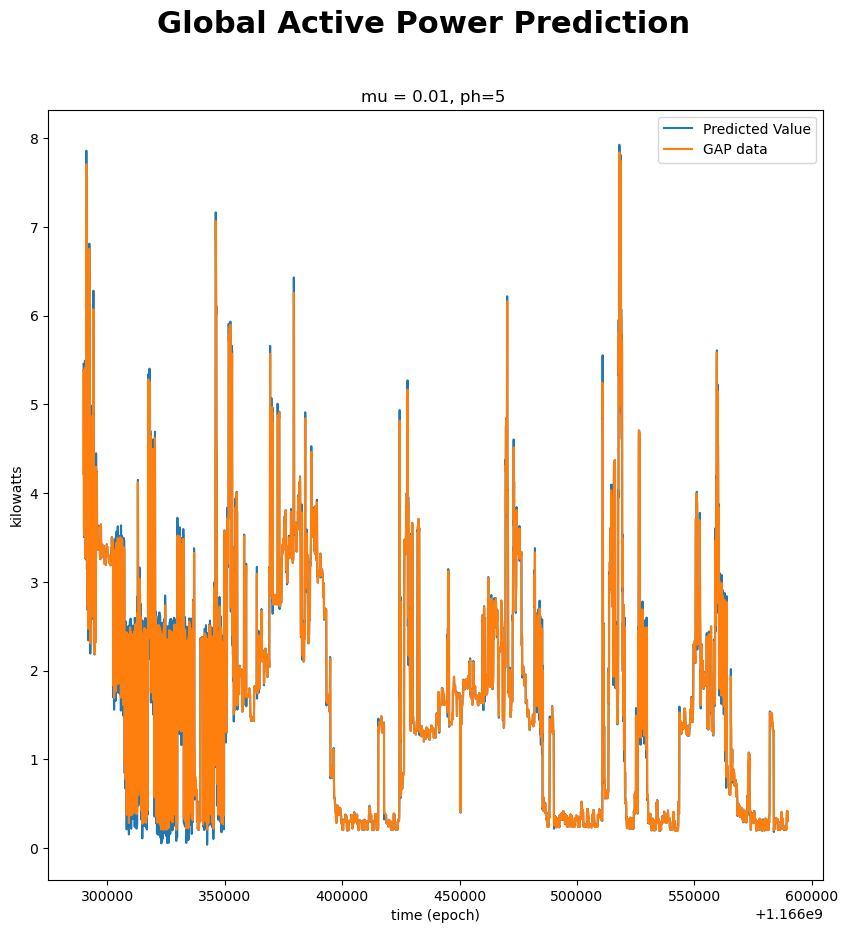

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

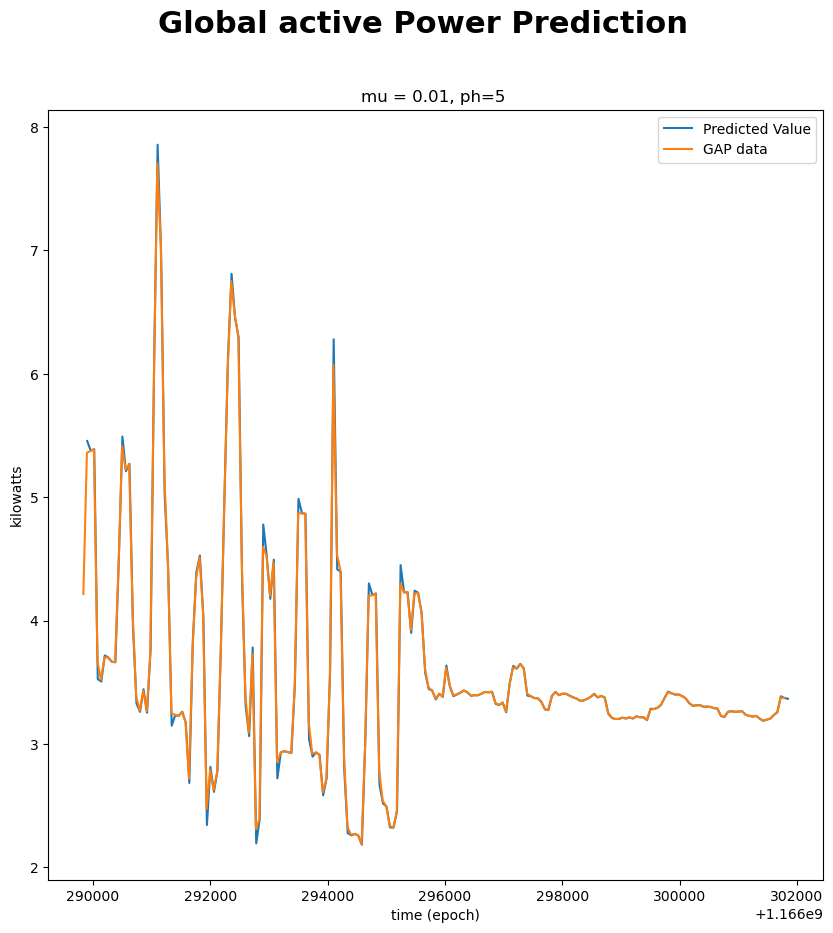

In [57]:
#Plot first 200 data points/predictions for mu = 0.01
total=[l for l in range(int(min(tp_pred)),int(min(tp_pred+3000)))]
thre=70*np.ones(len(total))
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction',fontsize=22,fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


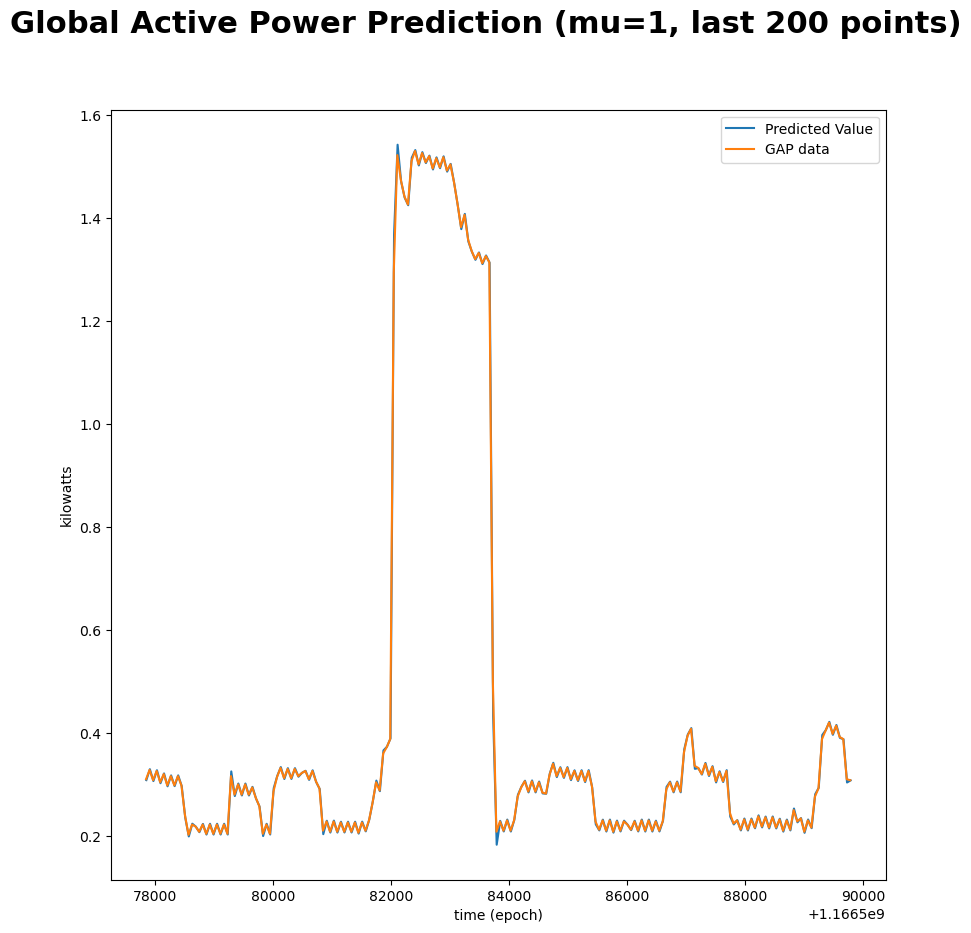

In [58]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=1, last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [59]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.2922694586515817


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: When mu = 1, we can see that the predicted and actual values in graphs vary considerably,
implying that increasing the mse values worsens the prediction.


**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The predicted values match the actual data, suggesting that the model with a mu value of 0.01 achieved good performance. The low MSE of 0.292 indicates that the model's predictions are reasonably accurate.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: According to the MSE values given, it seems that the model with mu = 0.9 has the lowest MSE of 0.1765, indicating that it performs better than the other two models. It should be noted that the best model depends on the specific problem and the requirements of the application. However, if the goal is to minimize the MSE, then the model with mu = 0.9 is the best choice.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We can enhance a model to increase its practicality and effectiveness through a technique called feature engineering. This involves choosing, generating, and modifying features within a dataset to enhance the performance of a machine learning model. By opting for superior features that are more pertinent to the problem at hand, the model can become more precise and proficient, resulting in improved accuracy and performance.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [76]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Voltage)

# Define model parameters
ph = 5 # 5 minutes
ph_index = int(ph/60) # how many timesteps is our ph?
mu = 0.9


# Limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [77]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
 
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
 
 #perform linear regression on "available" data using the mu-adjusted weigh
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
 #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
 #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp * tp + q_tmp
 
    tp_pred[i-2] = tp 
    yp_pred[i-2] = yp

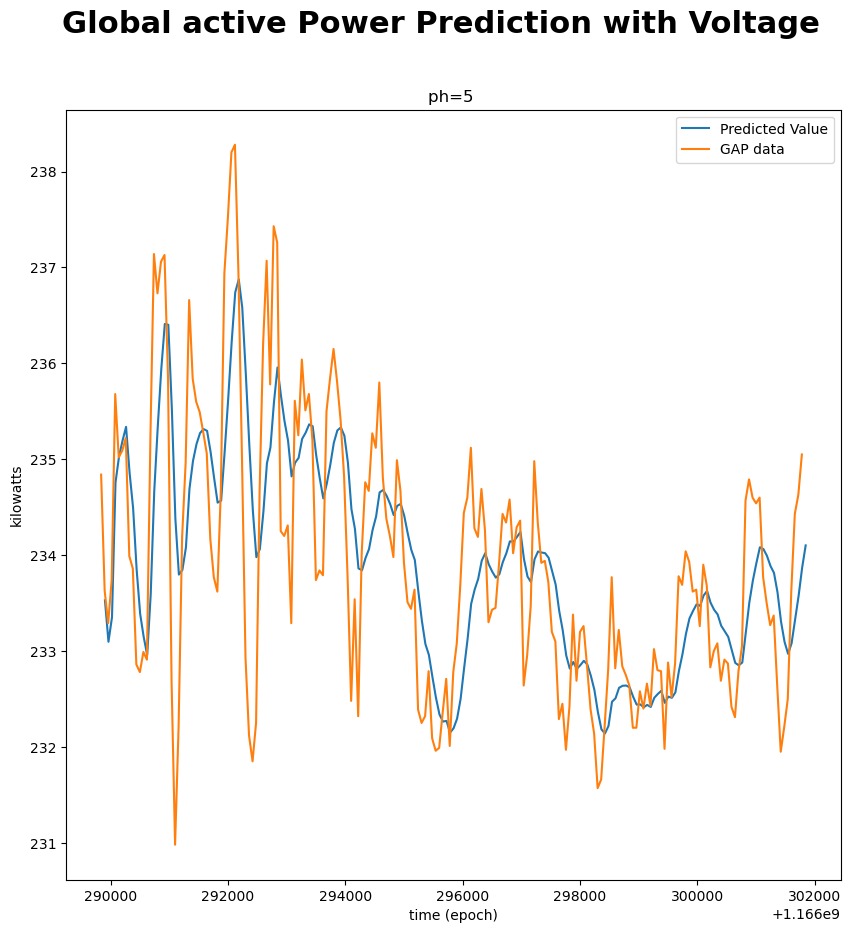

In [78]:
#Plot first 200 data points/predictions for the expanded dataset
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction with Voltage',fontsize=22,fontweight='bold')
ax.set_title('ph=%g ' %ph)
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


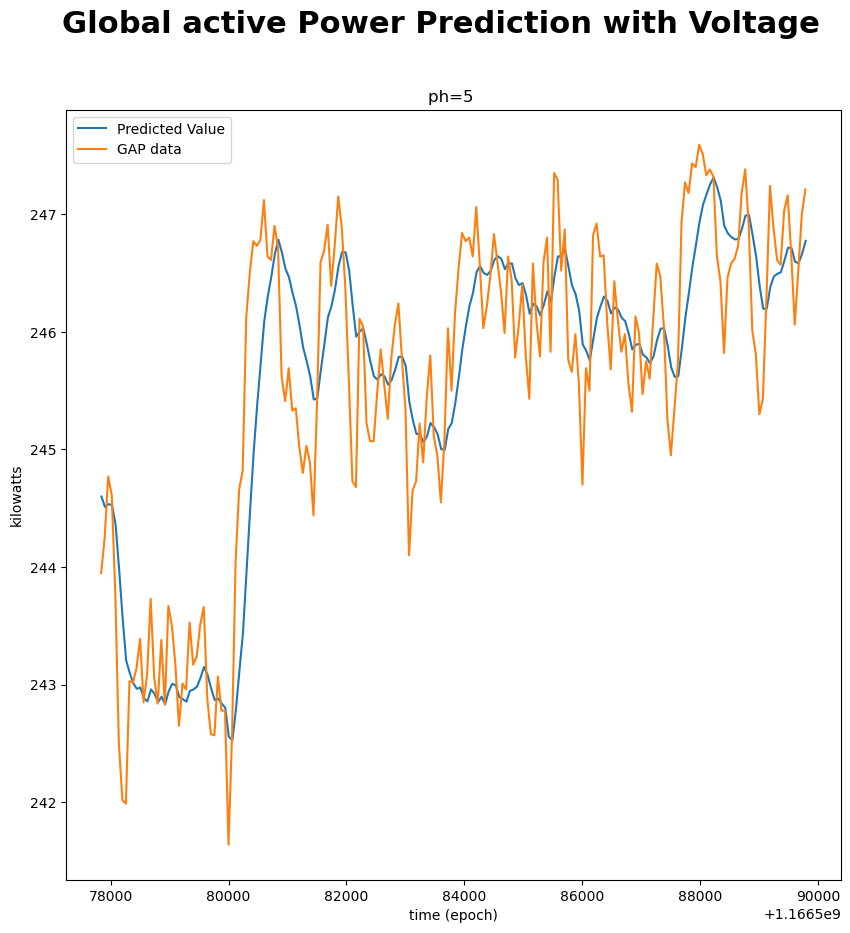

In [80]:
#Plot last 200 data points/predictions for the expanded data
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction with Voltage',fontsize=22,fontweight='bold')
ax.set_title('ph=%g ' %ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [82]:
#Calculate MSE of predictions for the expanded data
mse_val = mse(ys['Voltage'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_val)

MSE is 0.6325880328547184


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model with the added voltage data had a higher MSE of 3.63 compared to the models
without it. This suggests that adding the voltage data did not necessarily improve the model's
performance, and may have even made it worse.


There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: In this alternate model, I suggest replacing the use of a static mu factor with a dynamic moving window approach to constrain our predictions. This technique has the potential to encompass a greater range of variations in the data and improve the adaptability of our predictions. Rather than relying on a fixed mu factor to assign weight to the previous observation, we will predict the next observation by using a rolling window of preceding observations. As a result, the model will be more agile and better able to respond to shifts in the data, without being limited by a fixed weight.

In [ ]:
#create your alternative training data here
n=10
ys_ma=ys.rolling(n).mean()[n-1:]
ph = 5#5 minutes
ph_index = int(ph[:-3]) // 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [ ]:
#re-run the prediction code here
for i in range(n_s-1):
    if i==0:
        yp_pred[i]=ys.iloc[i,0]
    else:
        yp_pred[i]=yp_pred[i-1]+mu*(ys.iloc[i,0]-yp_pred[i-1])+mu*(ts.iloc[i-1,1]-yp_pred[i-1])
    tp_pred[i]=i+1

In [ ]:
#Plot first 200 data points/predictions for alternative model
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction with Voltage',fontsize=22,fontweight='bold')
ax.set_title('mu=%g,ph=%g ' %(mu,ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[ph_index:200+ph_index,0], ys_ma.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [ ]:
#Plot last 200 data points/predictions for alternative model
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('Global active Power Prediction with Voltage',fontsize=22,fontweight='bold')
ax.set_title('mu=%g,ph=%g ' %(mu,ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200-ph_index:n_s-ph_index,0], ys_ma.iloc[n_s-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [ ]:
#Calculate MSE of predictions for alternative model
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:The utilization of a moving average as the response variable in the alternate model did not yield better outcomes than before. Nonetheless, we could still improve the model using linear regression by employing polynomial regression. This approach enables us to model non-linear associations between the predictor variables and response variable. Additionally, we could attempt feature engineering, which involves constructing interaction terms between the predictor variables, to capture any non-linear associations that may exist.


It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.